In [33]:
import numpy as np
import pandas as pd
from PIL import Image
from typing import Tuple, Dict

# ===============================
# 1️⃣ Metric Functions
# ===============================
def accuracy_score(y_true, y_pred):
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    return float(np.mean(y_true == y_pred))

def confusion_matrix(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    labels = np.unique(np.concatenate([y_true, y_pred]))
    label_to_idx = {v: i for i, v in enumerate(labels)}
    cm = np.zeros((len(labels), len(labels)), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[label_to_idx[t], label_to_idx[p]] += 1
    return cm

def precision_recall_f1(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_true = y_true.astype(int).flatten()
    y_pred = y_pred.astype(int).flatten()

    labels = np.unique(np.concatenate([y_true, y_pred]))
    precisions, recalls, f1s = [], [], []
    for label in labels:
        tp = np.sum((y_pred == label) & (y_true == label))
        fp = np.sum((y_pred == label) & (y_true != label))
        fn = np.sum((y_pred != label) & (y_true == label))
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
    return {
        "labels": labels,
        "precision": np.array(precisions),
        "recall": np.array(recalls),
        "f1": np.array(f1s)
    }

# ===============================
# 2️⃣ Image Function
# ===============================
def array_to_image(arr, size=(28, 28)):
    a = np.array(arr).astype(np.uint8).reshape(size)
    return Image.fromarray(a)

# ===============================
# 3️⃣ Logistic Regression (Softmax)
# ===============================
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    expz = np.exp(z)
    return expz / np.sum(expz, axis=1, keepdims=True)

def one_hot(y, k):
    oh = np.zeros((len(y), k))
    oh[np.arange(len(y)), y] = 1
    return oh

class SoftmaxRegression:
    def __init__(self, n_features, n_classes, lr=0.1, reg=0.0):
        self.W = np.zeros((n_features, n_classes))
        self.b = np.zeros((1, n_classes))
        self.lr = lr
        self.reg = reg

    def predict_proba(self, X):
        logits = X.dot(self.W) + self.b
        return softmax(logits)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

    def fit(self, X, y, X_val=None, y_val=None, epochs=100, batch_size=256, verbose=True):
        n, d = X.shape
        classes = np.unique(y)
        C = len(classes)
        label_to_idx = {v: i for i, v in enumerate(classes)}
        idx_to_label = {i: v for v, i in label_to_idx.items()}
        y_idx = np.array([label_to_idx[v] for v in y])

        for epoch in range(1, epochs + 1):
            perm = np.random.permutation(n)
            X_sh = X[perm]
            y_sh = y_idx[perm]
            for i in range(0, n, batch_size):
                X_batch = X_sh[i:i + batch_size]
                y_batch = y_sh[i:i + batch_size]
                m = len(X_batch)
                probs = softmax(X_batch.dot(self.W) + self.b)
                y_onehot = one_hot(y_batch, C)
                grad_logits = (probs - y_onehot) / m
                gradW = X_batch.T.dot(grad_logits) + self.reg * self.W
                gradb = np.sum(grad_logits, axis=0, keepdims=True)
                self.W -= self.lr * gradW
                self.b -= self.lr * gradb

            # Track validation accuracy
            if verbose and epoch % max(1, epochs // 10) == 0:
                preds_train = np.argmax(softmax(X.dot(self.W) + self.b), axis=1)
                acc_train = np.mean(preds_train == y_idx)
                if X_val is not None and y_val is not None:
                    preds_val = np.argmax(softmax(X_val.dot(self.W) + self.b), axis=1)
                    acc_val = np.mean(preds_val == np.array([label_to_idx[v] for v in y_val]))
                    print(f"Epoch {epoch}/{epochs} - Train acc: {acc_train:.4f}, Val acc: {acc_val:.4f}")
                else:
                    print(f"Epoch {epoch}/{epochs} - Train acc: {acc_train:.4f}")

        self._label_to_idx = label_to_idx
        self._idx_to_label = idx_to_label

    def predict_labels(self, X):
        idxs = self.predict(X)
        return np.array([self._idx_to_label[i] for i in idxs])

# ===============================
# 4️⃣ MNIST Loader
# ===============================
def load_mnist_csv(path, label_col='label'):
    df = pd.read_csv(path)
    possible_labels = ['label', 'Label', 'digit', 'target']
    if label_col not in df.columns:
        for c in possible_labels:
            if c in df.columns:
                label_col = c
                break

    if label_col in df.columns:
        y = df[label_col].astype(int).values
        X = df.drop(columns=[label_col]).values
    else:
        y = None
        X = df.values

    X = X.astype(float)
    if X.max() > 1.0:
        X /= 255.0
    return X, y

# ===============================
# 5️⃣ Split Data (Train/Val)
# ===============================
def train_val_split(X, y, val_ratio=0.2, random_state=42):
    np.random.seed(random_state)
    n = len(y)
    indices = np.random.permutation(n)
    val_size = int(n * val_ratio)
    val_idx = indices[:val_size]
    train_idx = indices[val_size:]
    return X[train_idx], X[val_idx], y[train_idx], y[val_idx]

# ===============================
# 6️⃣ Training + Prediction Workflow
# ===============================
def run_mnist_training(train_csv, test_csv, epochs=50):
    # Load train data and split into train/val
    X_train_full, y_train_full = load_mnist_csv(train_csv)
    X_train, X_val, y_train, y_val = train_val_split(X_train_full, y_train_full, val_ratio=0.2)

    X_test, _ = load_mnist_csv(test_csv)

    print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

    n_features = X_train.shape[1]
    n_classes = len(np.unique(y_train))

    model = SoftmaxRegression(n_features=n_features, n_classes=n_classes, lr=0.5, reg=1e-4)
    model.fit(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=512)

    # Validation evaluation
    y_val_pred = model.predict_labels(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    metrics = precision_recall_f1(y_val, y_val_pred)
    print("\n=== Validation Metrics ===")
    print(f"Accuracy: {acc:.4f}")
    for lbl, p, r, f in zip(metrics["labels"], metrics["precision"], metrics["recall"], metrics["f1"]):
        print(f"Class {lbl}: Precision={p:.3f}, Recall={r:.3f}, F1={f:.3f}")

    # Predict for unlabeled test set
    y_test_pred = model.predict_labels(X_test)
    print("\n✅ Predictions for test.csv completed!")
    print(f"Total test samples: {len(y_test_pred)}")
    print("Example predictions:", y_test_pred[:10])

    # Save predictions
    output = pd.DataFrame({'ImageId': np.arange(1, len(y_test_pred) + 1), 'Label': y_test_pred})
    output.to_csv("mnist_test_predictions.csv", index=False)
    print("Predictions saved as 'mnist_test_predictions.csv'")

    return model, (X_val, y_val, X_test, y_test_pred)

# ===============================
# 7️⃣ Prediction for Single Image
# ===============================
def predict_image_and_label(flat_pixels, model):
    arr = np.array(flat_pixels).astype(float)
    if arr.max() > 1.0:
        arr /= 255.0
    img = array_to_image((arr * 255).astype(np.uint8))
    pred_label = model.predict_labels(arr.reshape(1, -1))[0]
    return img, pred_label

# ===============================
# ✅ Example Usage
# ===============================
# model, (X_val, y_val, X_test, y_test_pred) = run_mnist_training(
#     "MNIST_data/train.csv", "MNIST_data/test.csv", epochs=30)
# img, label = predict_image_and_label(X_test[0], model)
# img.show()
# print("Predicted:", label)


In [34]:
model, (X_val, y_val, X_test, y_test_pred) = run_mnist_training(
    "MNIST_data/train.csv", "MNIST_data/test.csv", epochs=30)
img, label = predict_image_and_label(X_test[0], model)
img.show()
print("Predicted:", label)

Train shape: (33600, 784), Val shape: (8400, 784), Test shape: (28000, 784)
Epoch 3/30 - Train acc: 0.9066, Val acc: 0.8987
Epoch 3/30 - Train acc: 0.9066, Val acc: 0.8987
Epoch 6/30 - Train acc: 0.9125, Val acc: 0.9096
Epoch 6/30 - Train acc: 0.9125, Val acc: 0.9096
Epoch 9/30 - Train acc: 0.9190, Val acc: 0.9140
Epoch 9/30 - Train acc: 0.9190, Val acc: 0.9140
Epoch 12/30 - Train acc: 0.9222, Val acc: 0.9136
Epoch 12/30 - Train acc: 0.9222, Val acc: 0.9136
Epoch 15/30 - Train acc: 0.9238, Val acc: 0.9152
Epoch 15/30 - Train acc: 0.9238, Val acc: 0.9152
Epoch 18/30 - Train acc: 0.9252, Val acc: 0.9161
Epoch 18/30 - Train acc: 0.9252, Val acc: 0.9161
Epoch 21/30 - Train acc: 0.9257, Val acc: 0.9180
Epoch 21/30 - Train acc: 0.9257, Val acc: 0.9180
Epoch 24/30 - Train acc: 0.9271, Val acc: 0.9154
Epoch 24/30 - Train acc: 0.9271, Val acc: 0.9154
Epoch 27/30 - Train acc: 0.9284, Val acc: 0.9171
Epoch 27/30 - Train acc: 0.9284, Val acc: 0.9171
Epoch 30/30 - Train acc: 0.9276, Val acc: 0.9160

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from math import log, pi, exp

# =========================
# Utility metric functions
# =========================
def accuracy_score(y_true, y_pred):
    return np.mean(np.array(y_true) == np.array(y_pred))

def confusion_matrix(y_true, y_pred):
    labels = np.unique(np.concatenate([y_true, y_pred]))
    label_to_idx = {v:i for i,v in enumerate(labels)}
    cm = np.zeros((len(labels), len(labels)), dtype=int)
    for t,p in zip(y_true, y_pred):
        cm[label_to_idx[t], label_to_idx[p]] += 1
    return labels, cm

def precision_recall_f1(y_true, y_pred):
    labels = np.unique(np.concatenate([y_true, y_pred]))
    metrics = {}
    for label in labels:
        tp = np.sum((y_pred == label) & (y_true == label))
        fp = np.sum((y_pred == label) & (y_true != label))
        fn = np.sum((y_pred != label) & (y_true == label))
        prec = tp / (tp + fp) if (tp + fp) else 0
        rec = tp / (tp + fn) if (tp + fn) else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) else 0
        metrics[label] = {'precision': prec, 'recall': rec, 'f1': f1}
    return metrics

# =========================
# Naive Bayes Classifier
# =========================
class NaiveBayesMixed:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # Laplace smoothing for categorical
        self.classes = None
        self.cat_features = []
        self.num_features = []
        self.class_priors = {}
        self.cat_cond_probs = {}  # P(x|y) for categorical
        self.num_params = {}      # mean, var for numeric

    def _gaussian_log_prob(self, x, mean, var):
        var = max(var, 1e-6)
        return -0.5 * log(2 * pi * var) - ((x - mean)**2) / (2 * var)

    def fit(self, X, y):
        df = X.copy()
        df['y'] = y
        self.classes = np.unique(y)
        cols = X.columns

        # Separate feature types
        for col in cols:
            if pd.api.types.is_numeric_dtype(X[col]):
                self.num_features.append(col)
            else:
                self.cat_features.append(col)

        # Class priors
        self.class_priors = {cls: np.log(np.mean(y == cls)) for cls in self.classes}

        # Numeric feature parameters
        self.num_params = {col: {} for col in self.num_features}
        for col in self.num_features:
            for cls in self.classes:
                vals = df.loc[df['y'] == cls, col].astype(float)
                self.num_params[col][cls] = (vals.mean(), vals.var(ddof=0))

        # Categorical feature probabilities
        self.cat_cond_probs = {col: {} for col in self.cat_features}
        for col in self.cat_features:
            values = X[col].astype(str).unique()
            V = len(values)
            for cls in self.classes:
                subset = df.loc[df['y'] == cls, col].astype(str)
                counts = subset.value_counts().to_dict()
                total = len(subset)
                probs = {}
                for val in values:
                    probs[val] = log((counts.get(val, 0) + self.alpha) / (total + self.alpha * V))
                self.cat_cond_probs[col][cls] = probs

    def _predict_row(self, row):
        log_probs = {}
        for cls in self.classes:
            log_prob = self.class_priors[cls]
            # Numeric features
            for col in self.num_features:
                x = float(row[col])
                mean, var = self.num_params[col][cls]
                log_prob += self._gaussian_log_prob(x, mean, var)
            # Categorical features
            for col in self.cat_features:
                val = str(row[col])
                if val in self.cat_cond_probs[col][cls]:
                    log_prob += self.cat_cond_probs[col][cls][val]
                else:
                    # unseen category
                    V = len(self.cat_cond_probs[col][cls])
                    log_prob += log(self.alpha / (self.alpha * V))
            log_probs[cls] = log_prob
        return max(log_probs, key=log_probs.get)

    def predict(self, X):
        preds = [self._predict_row(row) for _, row in X.iterrows()]
        return np.array(preds)

# =========================
# Data Split Function
# =========================
def stratified_split(df, target='y', test_size=0.3, random_state=42):
    np.random.seed(random_state)
    train_idx, test_idx = [], []
    for cls, subset in df.groupby(target):
        idx = subset.index.to_numpy()
        np.random.shuffle(idx)
        n_test = int(len(idx) * test_size)
        test_idx.extend(idx[:n_test])
        train_idx.extend(idx[n_test:])
    return df.loc[train_idx].reset_index(drop=True), df.loc[test_idx].reset_index(drop=True)

# =========================
# Run Naive Bayes on bank-full.csv
# =========================
def run_bank_naive_bayes(file_path="bank-full.csv"):
    df = pd.read_csv(file_path, sep=';')
    train_df, test_df = stratified_split(df, target='y', test_size=0.3)

    X_train, y_train = train_df.drop(columns=['y']), train_df['y'].values
    X_test, y_test = test_df.drop(columns=['y']), test_df['y'].values

    model = NaiveBayesMixed(alpha=1.0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    metrics = precision_recall_f1(y_test, y_pred)
    labels, cm = confusion_matrix(y_test, y_pred)

    print(f"\n=== Naive Bayes Evaluation on bank-full.csv ===")
    print(f"Accuracy: {acc:.4f}")
    for lbl, vals in metrics.items():
        print(f"{lbl}: Precision={vals['precision']:.3f}, Recall={vals['recall']:.3f}, F1={vals['f1']:.3f}")
    print("\nConfusion Matrix (rows=true, cols=pred):")
    print(pd.DataFrame(cm, index=labels, columns=labels))

    return model, (X_test, y_test, y_pred)




In [37]:
model, (X_test, y_test, y_pred) = run_bank_naive_bayes("bank-full.csv")



=== Naive Bayes Evaluation on bank-full.csv ===
Accuracy: 0.8667
no: Precision=0.935, Recall=0.912, F1=0.924
yes: Precision=0.441, Recall=0.521, F1=0.477

Confusion Matrix (rows=true, cols=pred):
        no   yes
no   10928  1048
yes    760   826


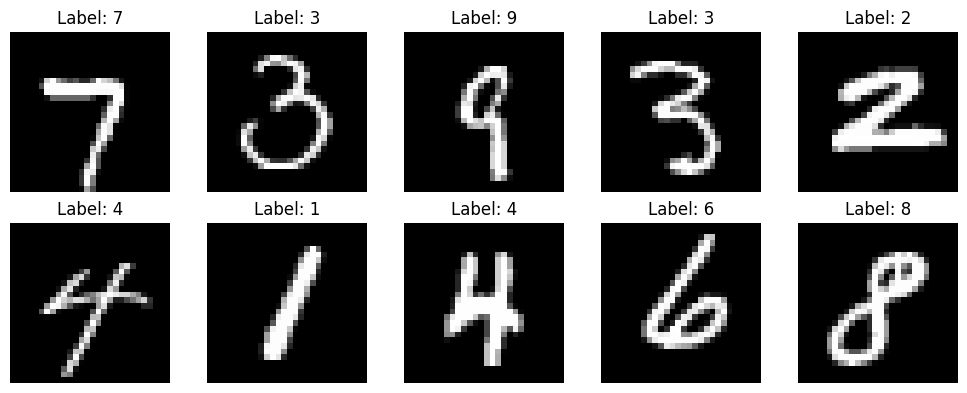

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ===============================
# Reuse your function
# ===============================
def array_to_image(arr, size=(28, 28)):
    """Convert a flat array (784 pixels) into a 28x28 grayscale PIL Image."""
    a = np.array(arr).astype(np.uint8).reshape(size)
    return Image.fromarray(a)

# ===============================
# Load MNIST CSV
# ===============================
# 🔹 Update this path to where your MNIST CSV actually is
mnist_train = pd.read_csv("MNIST_data/train.csv")

# Separate labels and pixel arrays
labels = mnist_train['label'].values
images = mnist_train.drop(columns=['label']).values

# ===============================
# Visualize a few random samples
# ===============================
plt.figure(figsize=(10, 4))
for i in range(10):
    idx = np.random.randint(0, len(images))  # pick a random sample
    img_array = images[idx]
    label = labels[idx]
    
    # Use your custom function
    img = array_to_image(img_array)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
